In [1]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(20,10)})
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
import math
from scipy.stats import f
#%pip install numpy_indexed
import datetime
from sklearn.model_selection import train_test_split
from scipy.stats import gaussian_kde

In [2]:
def interpolate_time(column_name, minutes, df4, interpolation_method):
    temp_df = df4.copy()
    jd_max_gap_fill = minutes/(60*24)
    
    #Get Value Gap
    temp_df['ffill'] = temp_df[column_name].interpolate(method=interpolation_method)
    temp_df['value_gap'] = temp_df[column_name].bfill() - temp_df[column_name].ffill()
    
    #Get Julian date
    temp_df['jd'] = temp_df.index.to_julian_date()
    
    #calculate time gap
    temp_df['jd_nan'] = np.where(~temp_df[column_name].isna(), temp_df['jd'], np.nan)
    temp_df['jd_gap'] = temp_df['jd_nan'].bfill() - temp_df['jd_nan'].interpolate(method=interpolation_method)
    
    #Time-wise, calculate how far into the value gap we are
    temp_df['jd_start'] = temp_df['jd_nan'].interpolate(method=interpolation_method)
    temp_df['jd_prp'] = np.where(temp_df['jd_gap'] != 0, (temp_df['jd'] - temp_df['jd_start'])/temp_df['jd_gap'], 0)
    
    #Calculate time-interpolated values
    temp_df['filled_OutletFlow'] = np.where(temp_df['jd_gap'] <= jd_max_gap_fill, temp_df['ffill'] + temp_df['value_gap'] * temp_df['jd_prp'], np.nan) 
    
    return temp_df['filled_OutletFlow']

In [3]:
def cleanseDf(df, target_, MDM_, pad_cols, inter_cols):
#df: fully populated dataframe
#target_: list [0]: Column name within df which is to be targetted, [1]: Threshold for rate of change
#MDM_: list [0]: Column name, [1]: Max non running current in units

#     new_df = df.copy()
# #     new_df[MDM_[0]] = new_df[MDM_[0]].interpolate(method = 'pad')
# #     new_df[fill_cols] = new_df[fill_cols].interpolate(method = 'pad') 
# #     new_df = new_df.interpolate()
#     for i in range(0, len(pad_cols)):
#         col = pad_cols[i]
#         #new_df[col] = interpolate_time(col, 2, new_df, "pad")
#         new_df[col] = new_df[col].interpolate(method='pad')
        
#     for i in range(0, len(inter_cols)):
#         col = inter_cols[i]
#         new_df[col] = interpolate_time(col, 0.3, new_df, "linear")
#         #new_df[col] = new_df[col].interpolate(method='linear')
        
    
#     new_df = new_df.dropna()
#     new_df = new_df[new_df[MDM_[0]]>MDM_[1]]

    new_df = df.copy()
    
    new_df['MDM current (A)'+' rolling diff']= new_df[MDM_[0]].diff().rolling(1000).mean()

    new_df = new_df.dropna()
    
    return new_df

In [4]:
def removeStateChanges(new_df, shift_by, upper_bound, lower_bound):
    
    
            
    sns.displot(new_df, x="MDM current (A) rolling diff", kde=True)
    #Shift by mean

    new_df["MDM current (A) rolling diff"] = new_df["MDM current (A) rolling diff"] - shift_by
    # #, compute threshold, 
    new_df["MDM current (A) rolling diff"] = new_df["MDM current (A) rolling diff"].abs()
    #shift back by mean 
    new_df["MDM current (A) rolling diff"] = new_df["MDM current (A) rolling diff"] + shift_by
    #shift threshold 
    upper_bound = upper_bound + shift_by
    
    
    print("Upper Bound Is" , upper_bound)
    #remove > threshold
    new_df = new_df[new_df["MDM current (A) rolling diff"]<upper_bound]
    
    return new_df

In [5]:
df = pd.read_csv("RawUptimeDataSets/Jan-MarchBrushyData.csv")

In [19]:
df['timestamp']= pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp')
df = df.sort_index()
df['VDV Pos [%] (%)'] = df['VDV Pos [%] (%)'].apply(lambda x: round(x,0))
df['IGV Pos [%] (%)'] = df['IGV Pos [%] (%)'].apply(lambda x: round(x,0))

if 'Main Header Press' in df:
    df = df.drop(["Inlet Air Pressure (Bar)", "Polytropic His (J/kg)", "Inlet Air Flow", "Main Header Flow", 
              "Main Header Press", "Normal Volume Flow (Nm3/hr)", "BOV Pos [%]", "Relative Pressure [%] (%)"], axis=1)
    
if 'E194: Ambient pressure (Bar)' in df:
    df = df.drop(["E194: Ambient pressure (Bar)"], axis=1)
    

df = df.drop("Actual Volume Flow (Nm3/sec)", axis=1)

df.head()

,MDM current (A),VDV Pos [%] (%),IGV Pos [%] (%),Isentropic His (J/kg),Phi
timestamp,,,,,
2022-01-01 00:05:57.861,95.704254,87.0,92.0,51745.296462,0.124977
2022-01-01 00:06:28.038,95.566917,87.0,92.0,51700.144043,0.124076
2022-01-01 00:07:27.984,95.715698,87.0,92.0,51623.709136,0.124356
2022-01-01 00:07:28.049,95.715698,87.0,92.0,51605.840256,0.124194
2022-01-01 00:08:28.214,95.486801,87.0,92.0,51477.661811,0.124177


In [20]:
df.count()

MDM current (A)          102042
VDV Pos [%] (%)          102042
IGV Pos [%] (%)          102042
Isentropic His (J/kg)    102042
Phi                      102042
dtype: int64

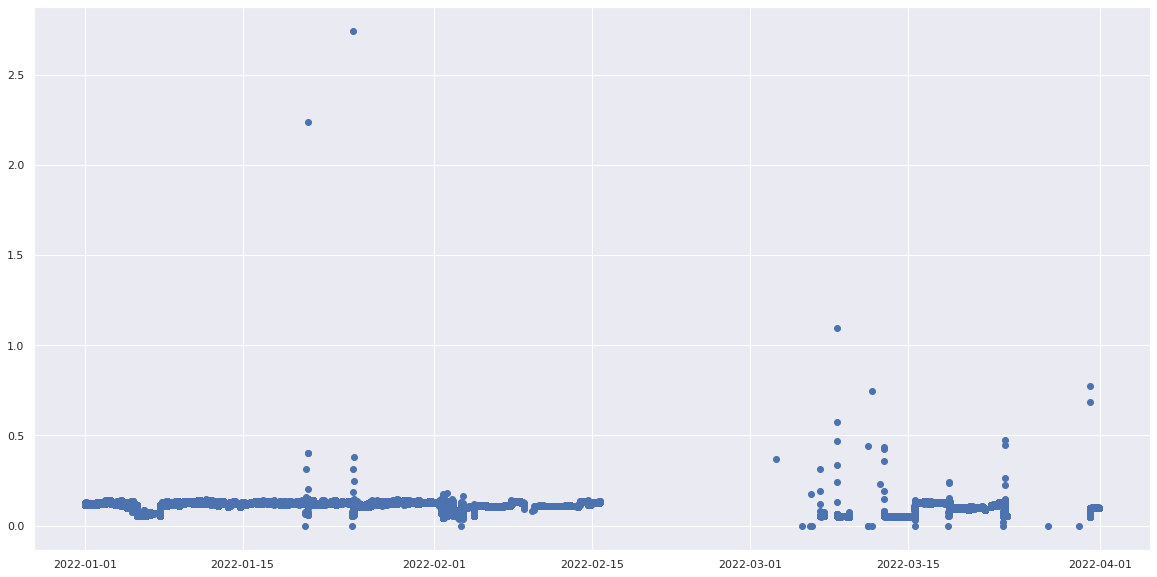

In [21]:
plt.scatter(x=df.index, y=df["Phi"])

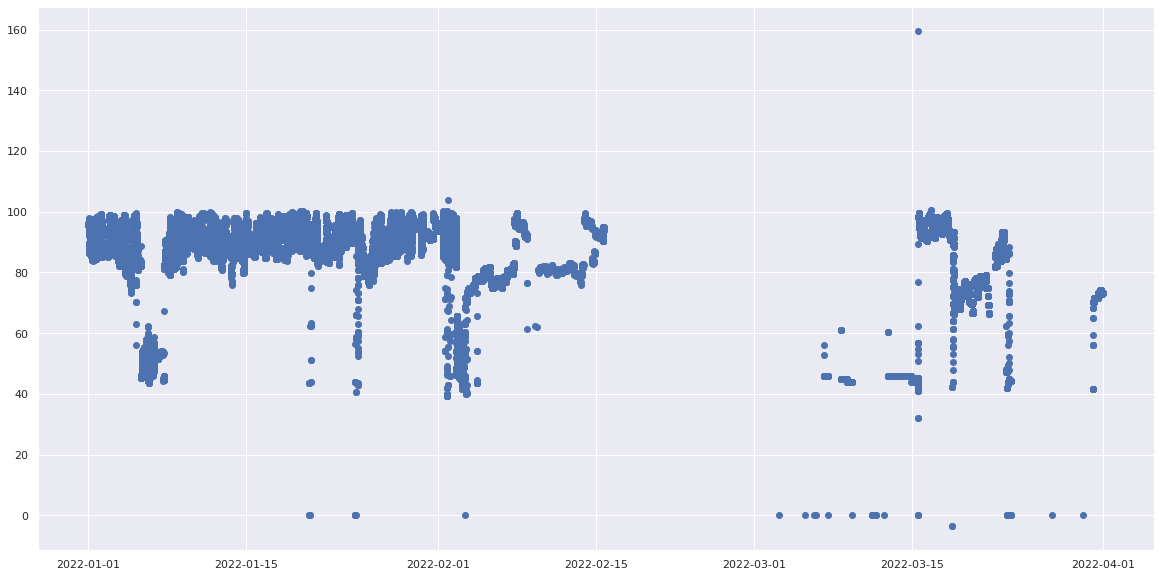

In [22]:
plt.scatter(x=df.index, y=df["MDM current (A)"])

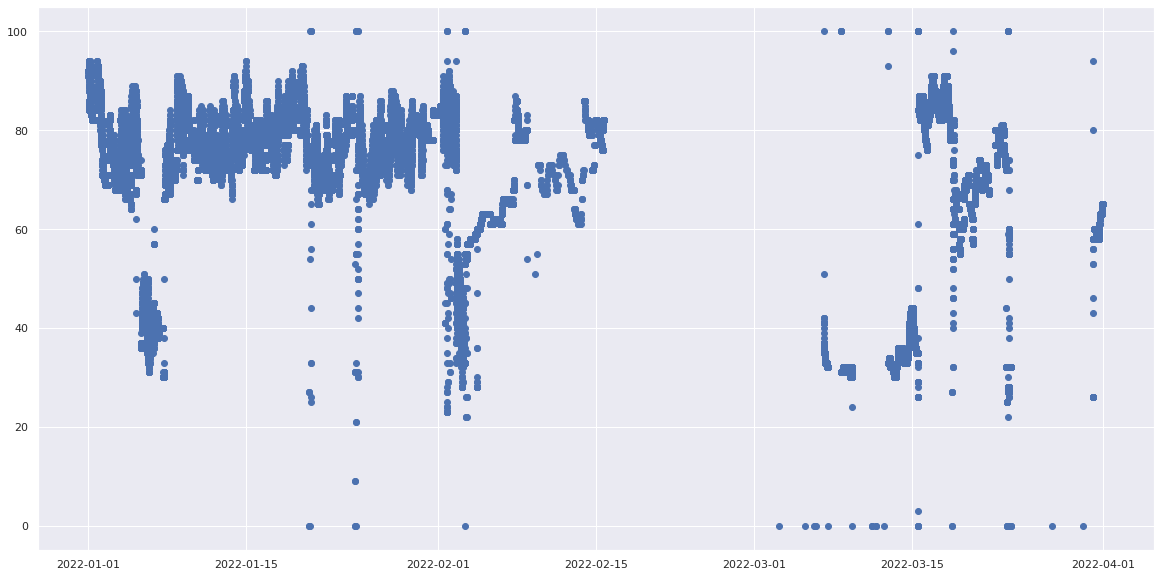

In [23]:
plt.scatter(x=df.index, y=df["IGV Pos [%] (%)"])

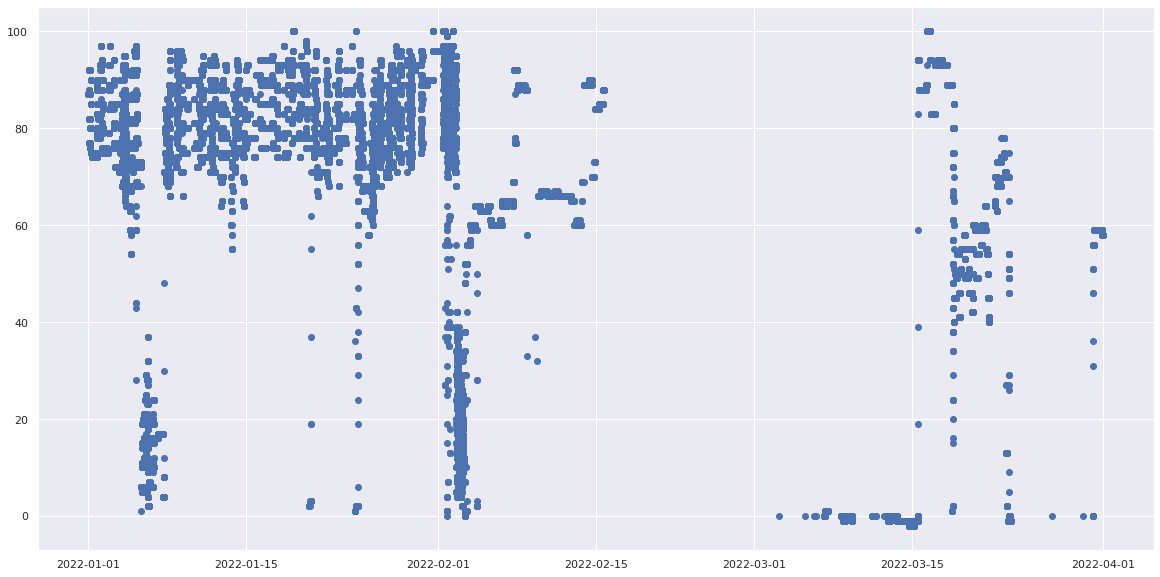

In [24]:
plt.scatter(x=df.index, y=df["VDV Pos [%] (%)"])

In [25]:
df["VDV Pos [%] (%)"].value_counts()

 89.0    6489
 93.0    6199
 88.0    5518
-1.0     4415
 90.0    4046
         ... 
 39.0      10
 3.0       10
 31.0       7
 44.0       3
 47.0       1
Name: VDV Pos [%] (%), Length: 103, dtype: int64

In [26]:
# subset = df.loc[(df.index < "2022-02-01")]
# subset.count()

In [27]:
# subset = df.loc[(df.index > "2022-01-04") & (df.index < "2022-01-04 03")]
# plt.scatter(x=subset.index, y=subset["VDV Pos [%] (%)"])
# sns.lineplot(data=subset, x=subset.index, y="VDV Pos [%] (%)")

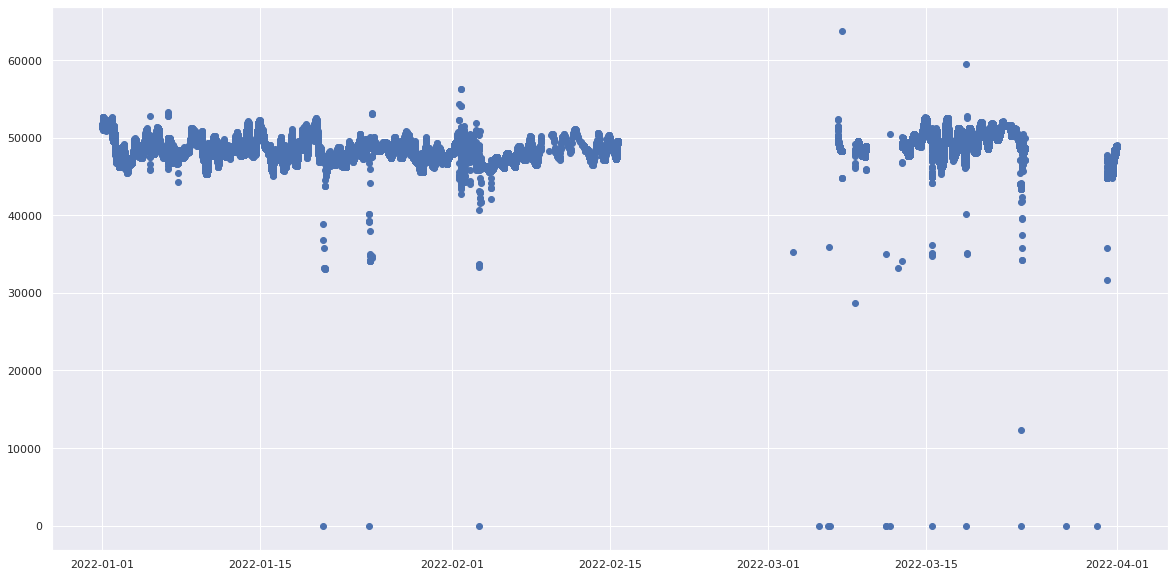

In [28]:
plt.scatter(x=df.index, y=df["Isentropic His (J/kg)"])

In [29]:
df.count()

MDM current (A)          102042
VDV Pos [%] (%)          102042
IGV Pos [%] (%)          102042
Isentropic His (J/kg)    102042
Phi                      102042
dtype: int64

In [30]:
pad_cols = ["IGV Pos [%] (%)", "VDV Pos [%] (%)", "MDM current (A)"]
inter_cols = ["Phi", "Isentropic His (J/kg)"]
for i in range(0, len(pad_cols)):
    col = pad_cols[i]
    #new_df[col] = interpolate_time(col, 2, new_df, "pad")
    df[col] = df[col].interpolate(method='pad')
        
for i in range(0, len(inter_cols)):
    col = inter_cols[i]
    df[col] = interpolate_time(col, 0.3, df, "linear")
    #new_df[col] = new_df[col].interpolate(method='linear')

df = df.dropna()

df.count()


MDM current (A)          102042
VDV Pos [%] (%)          102042
IGV Pos [%] (%)          102042
Isentropic His (J/kg)    102042
Phi                      102042
dtype: int64

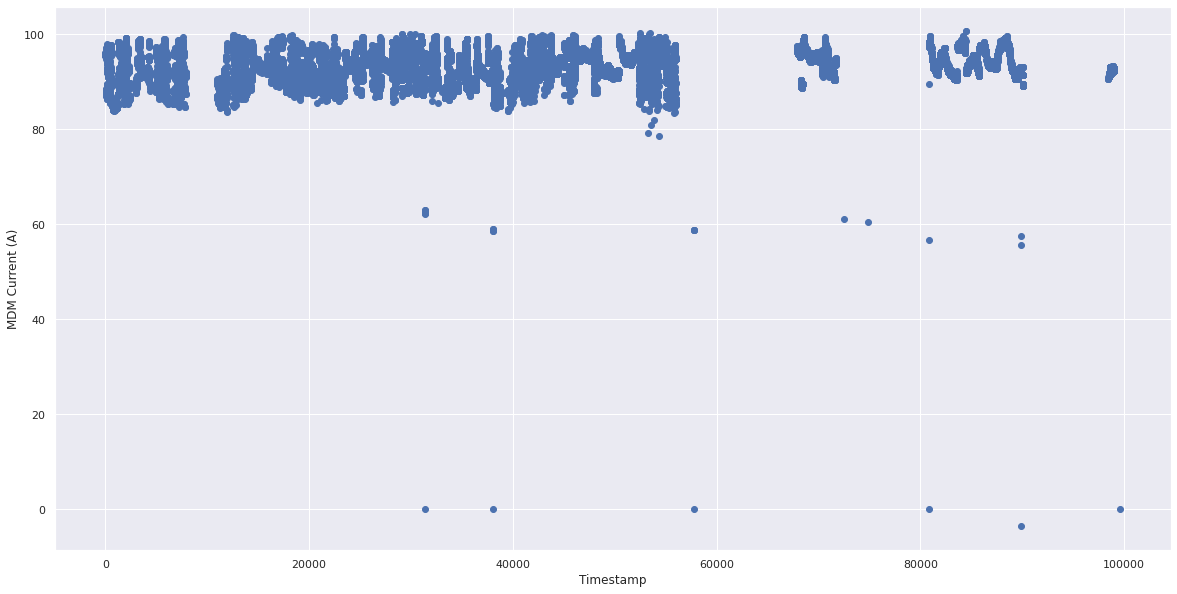

Upper bound for k=2 is 0.008701193676766979
Lower bound for k=2 is -0.008701193676766979
Upper Bound Is 0.008761278545373417


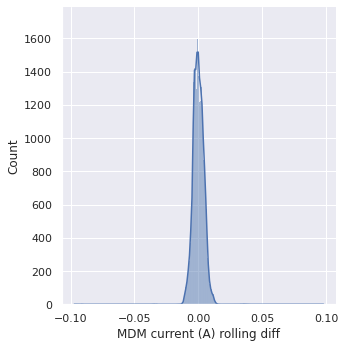

In [31]:
model = pd.read_pickle(r'Running/Not Running Classification/runningclassifier.pkl')

df = df.reset_index()
# print(df.head())



X = df.drop(["timestamp"], axis=True)
predictions = model.predict(X)
df["Running"] = predictions
df = df.loc[df["Running"]==1]
# df = df.set_index('timestamp')
# df = df.sort_index()

plt.scatter(x=df.index, y=df["MDM current (A)"])
plt.ylabel("MDM Current (A)")
plt.xlabel("Timestamp")
plt.show()

df = df.set_index('timestamp')


a = ["Phi", 0]
b = ["MDM current (A)", 40]






#fill_cols = ["IGV Pos [%] (%)", "VDV Pos [%] (%)", "Isentropic His (J/kg)"]
df = cleanseDf(df, a, b, pad_cols, inter_cols)


shift_by = df["MDM current (A) rolling diff"].mean()
df["MDM current (A) rolling diff"] = df["MDM current (A) rolling diff"] - shift_by
mu_mdm = df["MDM current (A) rolling diff"].mean()
std_mdm = df["MDM current (A) rolling diff"].std()
k = 2
upper_bound = mu_mdm + k * std_mdm
lower_bound = mu_mdm - k * std_mdm


print(f"Upper bound for k={k} is {upper_bound}")
print(f"Lower bound for k={k} is {lower_bound}")

df = removeStateChanges(df, shift_by, upper_bound, lower_bound)
df.drop("MDM current (A) rolling diff", axis=1, inplace=True)

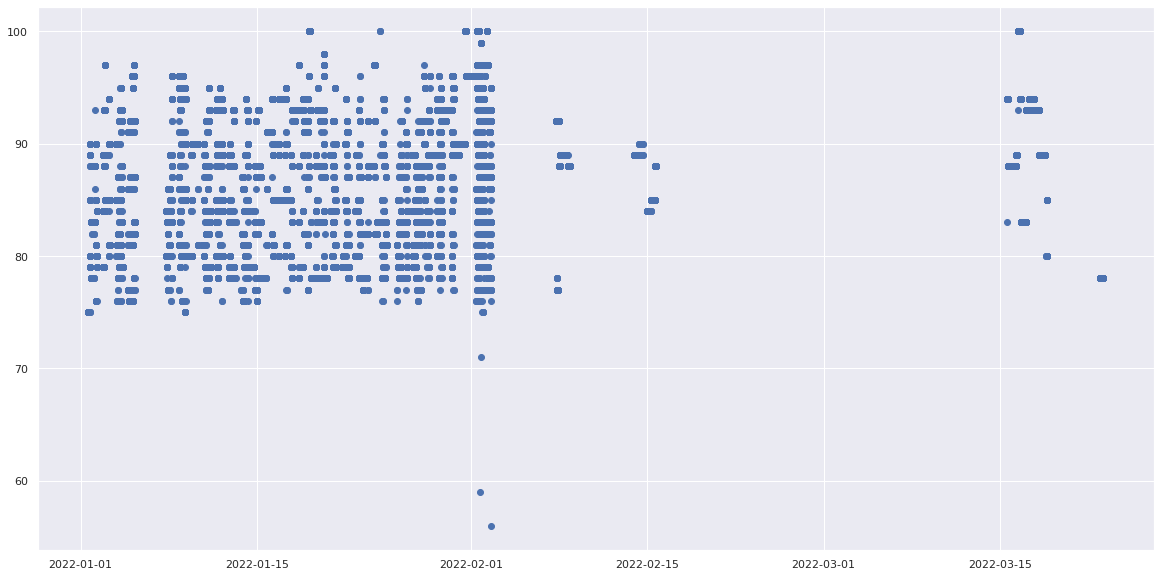

In [32]:
plt.scatter(x=df.index, y=df["VDV Pos [%] (%)"])

In [33]:
df.index.unique()

DatetimeIndex(['2022-01-01 15:05:10.233000', '2022-01-01 15:07:40.672000',
               '2022-01-01 15:08:10.665000', '2022-01-01 15:08:40.827000',
               '2022-01-01 15:09:10.980000', '2022-01-01 15:09:41.104000',
               '2022-01-01 15:10:41.319000', '2022-01-01 15:11:11.398000',
               '2022-01-01 15:12:41.986000', '2022-01-01 15:16:11.899000',
               ...
               '2022-03-23 04:10:39.724000', '2022-03-23 04:11:09.660000',
               '2022-03-23 04:11:39.587000', '2022-03-23 04:12:09.641000',
               '2022-03-23 04:12:39.612000', '2022-03-23 04:12:39.712000',
               '2022-03-23 04:17:09.989000', '2022-03-23 04:18:09.820000',
               '2022-03-23 04:19:40.013000', '2022-03-23 04:20:09.873000'],
              dtype='datetime64[ns]', name='timestamp', length=50897, freq=None)

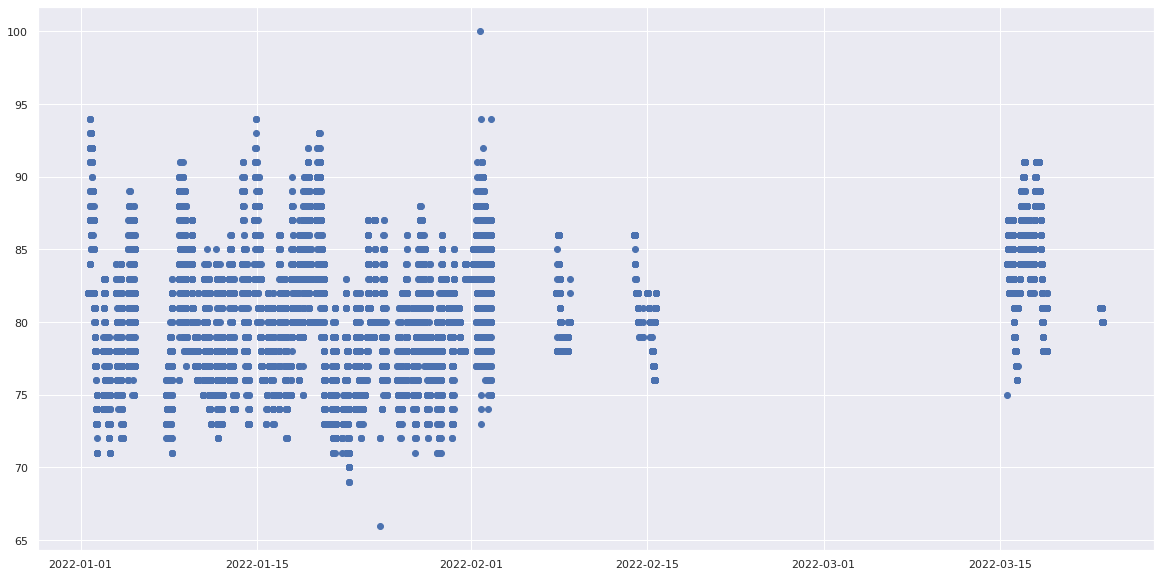

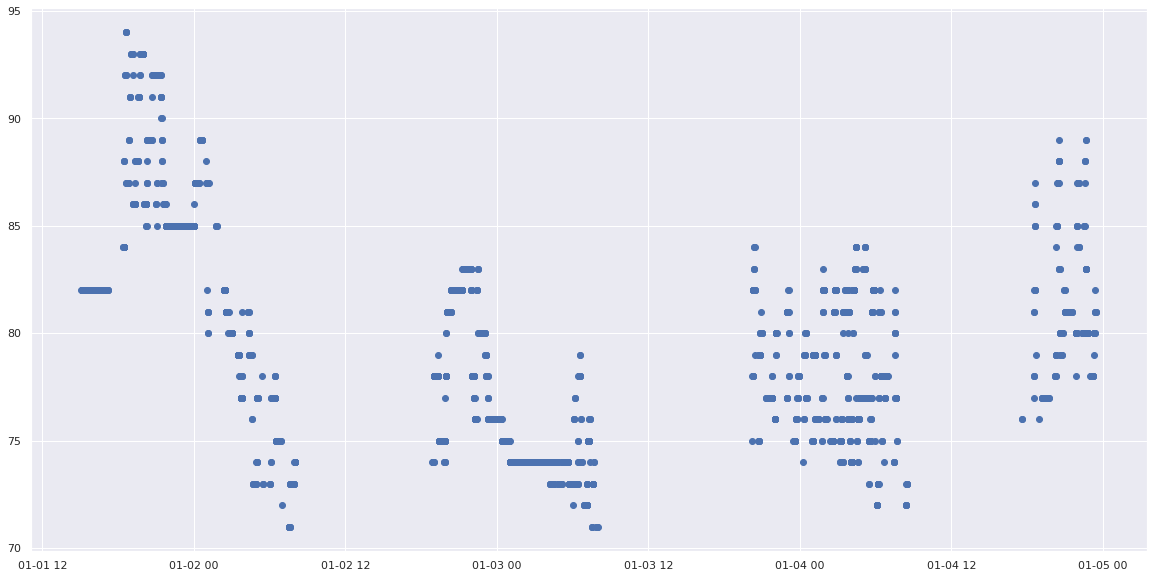

In [34]:
plt.scatter(x=df.index, y=df["IGV Pos [%] (%)"])
plt.show()
subset = df.loc[df.index<"2022-01-05"]
plt.scatter(x=subset.index, y=subset["IGV Pos [%] (%)"])

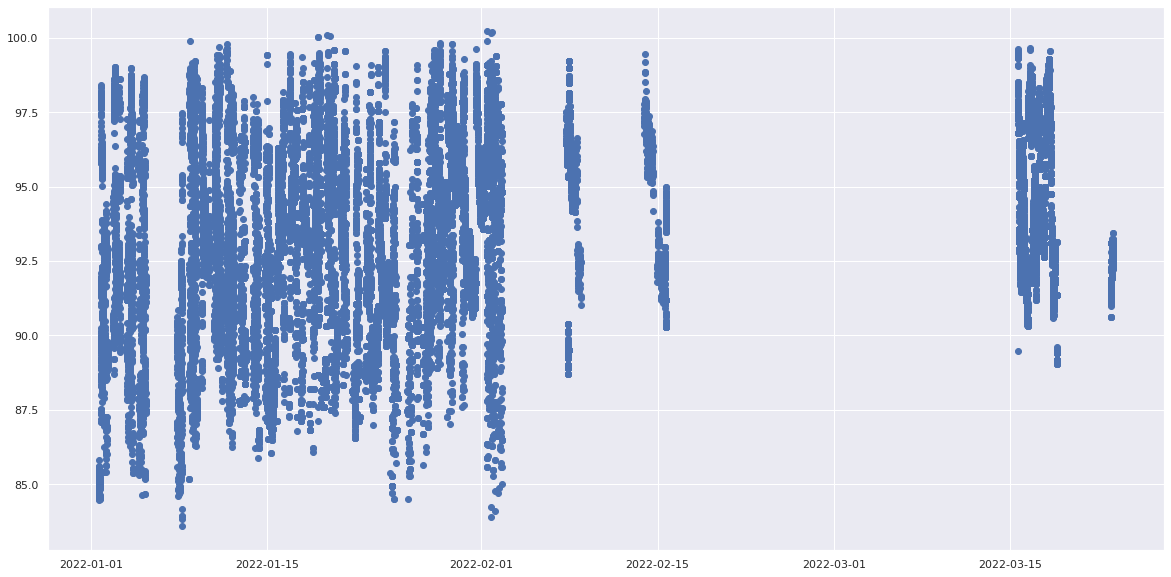

In [35]:
plt.scatter(x=df.index, y=df["MDM current (A)"])

In [ ]:
plt.scatter(x=df.index, y=df["Phi"])

In [ ]:
plt.scatter(x=df.index, y=df["Isentropic His (J/kg)"])

In [ ]:
df = df.sort_index()
df = df.reset_index()
change = df['VDV Pos [%] (%)'].diff()
change_2 = df['IGV Pos [%] (%)'].diff()
step_length = df['timestamp'].diff()
since_change = []
current_delta = 0
for is_change, is_change2, delta in zip(change, change_2, step_length):
    current_delta = 0 if (is_change != 0 or is_change2 != 0) else \
        current_delta + delta.total_seconds() 
    since_change.append(current_delta)
df['Time Since Combination Change'] = pd.Series(since_change).values

In [ ]:
unique = df.groupby(['IGV Pos [%] (%)','VDV Pos [%] (%)']).size().reset_index()
for i in range(0, len(unique)):
    IGV = unique["IGV Pos [%] (%)"][i]
    VVD = unique["VDV Pos [%] (%)"][i]
    subset = df.loc[(df["IGV Pos [%] (%)"]==IGV) & (df["VDV Pos [%] (%)"]==VVD)]
    plt.scatter(x=subset["Time Since Combination Change"], y=subset["Actual Volume Flow (Nm3/sec)"])
    plt.show()

In [ ]:
result = df.copy()

In [ ]:
unique = result.groupby(['IGV Pos [%] (%)','VDV Pos [%] (%)']).size().reset_index()
unique = unique.rename(columns={0:'Count'})
remove = unique.loc[unique["Count"]<50].reset_index()

removes_combs = []
for i in range(0, len(remove)):
    IGV = remove["IGV Pos [%] (%)"][i]
    VVD = remove["VDV Pos [%] (%)"][i]
    removes_combs.append([IGV, VVD])
removes_combs


for i in range(0, len(removes_combs)):
    IGV = removes_combs[i][0]
    VVD = removes_combs[i][1]
    result = result.loc[np.invert((result["IGV Pos [%] (%)"]==IGV) & (result["VDV Pos [%] (%)"]==VVD))]

In [ ]:
unique = result.groupby(['IGV Pos [%] (%)','VDV Pos [%] (%)']).size().reset_index()
unique = unique.rename(columns={0:'Count'})
indexes_to_remove = []
for i in range(0, len(unique)):
    IGV = unique["IGV Pos [%] (%)"][i]
    VVD = unique["VDV Pos [%] (%)"][i]

    comb = result.loc[(result["IGV Pos [%] (%)"]==IGV)&(result["VDV Pos [%] (%)"]==VVD)]
    xy = np.vstack([comb['Phi'],comb['Isentropic His (J/kg)']])
    z = gaussian_kde(xy)(xy)
    comb["Density"] = z.tolist()
    plt.title("Raw Data")
    plt.scatter(x=comb["Phi"], y=comb["Isentropic His (J/kg)"], c=comb["Density"])
    plt.xlabel("Phi")
    plt.ylabel("Isentropic His (J/kg)")
    plt.show()
    
    print("For IGV:", IGV)
    print("For VVD:", VVD)
    density_threshold = np.percentile(comb["Density"], 30)
    comb1 = comb.loc[comb["Density"]>density_threshold]
    comb = comb.loc[comb["Density"]<density_threshold]
    result = result.drop(comb.index)
    
    plt.title("Dense Data")
    plt.scatter(x=comb1["Phi"], y=comb1["Isentropic His (J/kg)"], c=comb1["Density"])
    plt.xlabel("Phi")
    plt.ylabel("Isentropic His (J/kg)")
    plt.show()

In [ ]:
plt.scatter(x=result.index, y=result["IGV Pos [%] (%)"])

In [ ]:
plt.scatter(x=result.index, y=result["VDV Pos [%] (%)"])

In [ ]:
# df.to_csv("CleansedDataSets/JulyCleansed.csv")

In [ ]:
sns.heatmap(df.corr(), annot=True)